In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
import scipy.stats as st
from statsmodels.stats.proportion import proportion_confint

In [2]:
# Import data
skill_lookup = {
    1: "Novice",
    2: "Novice",
    3: None,
    4: "Proficient",
    5: "Proficient",
    6: None,
    7: "Expert"
}
league_lookup = {
    1: "Bronze",
    2: "Silver",
    3: "Gold",
    4: "Platinum",
    5: "Diamond",
    6: "Master",
    7: "Grandmaster"
}
# WIN
data = pd.read_csv("all_stats_win_combined.csv")
data = data.drop(["Unnamed: 0", "game_id"], 1)
data["cpm"] = data.apply(lambda r: r['cps']*60, axis = 1)
data["rel_cpm"] = data.apply(lambda r: r['rel_cps']*60, axis = 1)
data_by_rank = [data[data['rank'] == rank] for rank in league_lookup.keys()]
data_by_region_win_all = [data[data['Region'] == region] for region in data.Region.unique()]

/tmp/ipykernel_20489/1307060010.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop(["Unnamed: 0", "game_id"], 1)


In [3]:
# SKILL
data_uid_skill = pd.read_csv("all_stats_skill_combined.csv")
data_uid_skill = data_uid_skill.drop(["Unnamed: 0", "game_id"], 1)
data_uid_skill["cpm"] = data_uid_skill.apply(lambda r: r['cps']*60, axis = 1)
data_uid_skill["rel_cpm"] = data_uid_skill.apply(lambda r: r['rel_cps']*60, axis = 1)
data_uid_skill = data_uid_skill[data_uid_skill['rank'].isin([1, 2, 4, 5, 7])].copy()
data_uid_skill["skill"] = data_uid_skill.apply(lambda r: skill_lookup[r['rank']], axis = 1)
data_uid_skill = data_uid_skill.groupby(["uid", "skill", "Region"], as_index = False).mean()
data_all_skill = data_uid_skill
data_uid_skill = data_uid_skill.groupby('skill', as_index = False).apply(lambda r: r.sample(n = 1800))
# data_by_region_skill = [data_uid_skill[data_uid_skill['Region'] == region] for region in data_uid_skill.Region.unique()]

/tmp/ipykernel_20489/996119824.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_uid_skill = data_uid_skill.drop(["Unnamed: 0", "game_id"], 1)


In [4]:
# SKILL US
data_skill_us = data_all_skill[data_all_skill['Region'] == "us"]
data_skill_us = data_skill_us.groupby('skill', as_index = False).apply(lambda r: r.sample(n = 600))
# SKILL EU
data_skill_eu = data_all_skill[data_all_skill['Region'] == "eu"]
data_skill_eu = data_skill_eu.groupby('skill', as_index = False).apply(lambda r: r.sample(n = 600))

In [5]:
# WIN BY RANK
data_uid_rank = pd.read_csv("all_stats_win_combined.csv") 
data_uid_rank = data_uid_rank.drop(["Unnamed: 0", "game_id"], 1)
data_uid_rank["cpm"] = data_uid_rank.apply(lambda r: r['cps']*60, axis = 1)
data_uid_rank["rel_cpm"] = data_uid_rank.apply(lambda r: r['rel_cps']*60, axis = 1)
data_uid_rank = data_uid_rank[data_uid_rank['rank'].isin([1, 2, 3, 4, 5, 6, 7])].copy()
data_uid_rank = data_uid_rank.groupby(["uid", "rank", "win", "Region"], as_index = False).mean()
data_uid_rank = data_uid_rank.groupby('rank', as_index = False).apply(lambda r: r.sample(n = 800))
data_uid_rank['rank'] = pd.Categorical(data_uid_rank['rank'])
data_win_all = data_uid_rank
data_by_region_win = [data_uid_rank[data_uid_rank['Region'] == region] for region in data_uid_rank.Region.unique()]

In [6]:
# WIN US
data_win_us = data_win_all[data_win_all['Region'] == "us"]
# WIN EU
data_win_eu = data_win_all[data_win_all['Region'] == "us"]

In [10]:
labels_win = {
    'rel_scout_rate_all': 'Relative Scouting Rate (instances/second)', 
    'rel_cpm': 'Relative Control Group Commands per Minute', 
    'rel_apm': 'Relative Actions per Minute',      
    'rel_hotkey_rate': 'Relative Camera Hotkey Creation Rate (instances/second)', 
    'rel_hotkey_usage_rate': 'Relative Hotkey Camera Usage Rate (instances/second)', 
    'game_length': 'Game Length (seconds)'
}

labels_skill = {
    'scout_rate_all': 'Scouting Rate (instances/second)', 
    'apm': 'Actions per Minute',            
    'cpm': 'Control Group Commands per Minute',  
    'hotkey_rate': 'Camera Hotkey Creation Rate (instances/second)', 
    'hotkey_usage_rate': 'Camera Hotkey Usage Rate (instances/second)',           
    'abs_rel_total_army': 'Mean Difference in Army Size', 
    'offense_lower_army_rate': 'Rate of Offensive Engagements with Smaller Army'
}

In [14]:
def mean_2darray(arr_list):
    res = arr_list[0]
    for i in range(1, len(arr_list)):
        res += arr_list[i]
    return res/len(arr_list)
    
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]
        
def dummyPredict(df, predictors_list, responses):
    dummy_clf = DummyClassifier(strategy="most_frequent")
    X = df[predictors].values
    y = df[responses].values.ravel()
    dummy_clf.fit(X, y)
    dummy_clf.predict(X)
    print("Baseline accuracy:", dummy_clf.score(X, y))
    
def score_est(est, X, y, cv):
    if X.shape[1] > 1:
        selector = RFECV(est, step=1, cv=cv)
        selector.fit(X, y)
        X_sel = selector.transform(X)
        support = selector.get_support()
    else:
        X_sel = X
        support = np.array([True])
    # score for these params is CV score fitting on X_sel
    scores = cross_val_score(est, X_sel, y, cv=cv)
    CI_list = [np.array(proportion_confint(score*X_sel.shape[0], X_sel.shape[0])) 
              for score in scores]
    CI = pd.DataFrame(CI_list).mean()
    return np.mean(scores), CI, support

def plot_features_importance(plot_info, skill = False):
    rank_index = 1
    plot_index = 1
    for plot_info_by_rank in plot_info:
        rank = league_lookup[rank_index]
        feature_importance = plot_info_by_rank[0]
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        fig = plt.figure(figsize=(15, 7))
        if skill:
            labels_dict = labels_skill
        else:
            labels_dict = labels_win
            
        plt.subplot(2, 1, plot_index)
        labels = [labels_dict[label] for label in plot_info_by_rank[2][sorted_idx]]
        plot_index += 1
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, labels)
        plt.title('Feature Importance (MDI) ')
#         else:
#             plt.title('Feature Importance (MDI) ' + rank)
        
        perm_importances = plot_info_by_rank[1]
        importances_mean = perm_importances.mean(axis = 1)
        sorted_idx = importances_mean.argsort()
        plt.subplot(2, 1, plot_index)
        plot_index += 1
        labels = [labels_dict[label] for label in plot_info_by_rank[2][sorted_idx]]
        plt.boxplot(perm_importances[sorted_idx].T,
                    vert=False, labels = labels)
#         if skill:
        plt.title("Permutation Importance (test set) ")
#         else:
#             plt.title("Permutation Importance (test set) " + rank)
        fig.tight_layout()
        fig.patch.set_facecolor('white')
        rank_index += 1 
    plt.show()

def predict(df, model, predictors, responses, grid, pool):
    # Take X, y 
    X = df[predictors].values
    y = df[responses].values.ravel()
    # cross validation method - stratified k-fold
    skf = StratifiedKFold(n_splits=10)
    tasks = []
    var_importances = []
    perm_importances = []
    for params in grid:
        param_scores = []
        est = model(**params)
        tasks.append((pool.apply_async(score_est, (est, X, y, skf)), 
                      params))
    scores = [(task.get(), params) for task, params in tasks]
    (avg_score, CI, support), best_params = max(scores, key=lambda x: x[0])
    best_model = model(**best_params)
    X_sel = X[:, support]
    for train_index, test_index in skf.split(X_sel, y):
        X_train, X_test = X_sel[train_index], X_sel[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_model.fit(X_train, y_train)
        var_importances.append(best_model.feature_importances_)
        perm_importance = permutation_importance(best_model, X_test, y_test, 
                                                 n_repeats = 10, random_state = 42, 
                                                 n_jobs = 2).importances
        perm_importances.append(perm_importance)
    var_importances = pd.DataFrame(var_importances, columns = np.array(predictors)[support])
    print("Accuracy:", avg_score)
    print("95% Confidence Interval", CI[0], CI[1])
    print("Parameters", best_params)
    print("====================0.0====================")
    return var_importances.mean(), mean_2darray(np.array(perm_importances)), np.array(predictors)[support]

In [5]:
predictors_win = ['rel_scout_rate_all', 'rel_cpm', 'rel_apm',
             'rel_hotkey_rate', 'rel_hotkey_usage_rate', 'rel_macro_rate', 'game_length']
predictors_win_reviewed = ['rel_scout_rate_all', 'rel_cpm', 'rel_apm',
             'rel_hotkey_rate', 'rel_hotkey_usage_rate']
predictors_powerset_win = list(powerset(predictors_win))
predictors_powerset_win.pop(0)

predictors_win_old = ['scout_rel_freq', 'rel_cpm', 'rel_apm', 'game_length']
predictors_powerset_win_old = list(powerset(predictors_win_old))
predictors_powerset_win_old.pop(0)

# print(predictors_powerset_win[len(predictors_powerset_win) - 1:])
# print(predictors_powerset_win)

predictors_skill = ['scout_rate_all', 'apm',
                    'cpm', 'macro_rate', 'hotkey_rate', 'hotkey_usage_rate', 
                    'abs_rel_total_army', 'offense_lower_army_rate']
predictors_skill_reviewed = ['scout_rate_all', 'apm',
                    'cpm', 'hotkey_rate', 'hotkey_usage_rate']
predictors_powerset_skill = list(powerset(predictors_skill))
predictors_powerset_skill.pop(0)
predictors_powerset_skill_short = [predictors_powerset_skill[len(predictors_powerset_skill) - 1],
                                  predictors_powerset_skill[1], predictors_powerset_skill[3],
                                  predictors_powerset_skill[31]]

In [6]:
# Skill 
grid_quick = {"loss": ["deviance"], "max_depth": [5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01], "subsample": [0.5], "random_state": [1]}
res_skill = []
# with Pool(15) as pool:
#     for predictors in predictors_powerset_skill_short:
#         var_imp, perm_imp, predictors = predict(data_uid_skill, GradientBoostingClassifier, 
#                                                 predictors,
#                                                 ['skill'], ParameterGrid(grid_quick), pool)
#         res_skill.append((var_imp, perm_imp, predictors))

In [14]:
# Skill by region
res_skill_region = []
with Pool(15) as pool:
    for data_region in data_by_region_skill:
        var_imp, perm_imp, predictors = predict(data_region, GradientBoostingClassifier, 
                                                predictors_skill,
                                                ['skill'], ParameterGrid(grid_quick), pool)
        res_skill_region.append((var_imp, perm_imp, predictors))

Accuracy: 0.7757460117925234
95% Confidence Interval 0.7596940407440902 0.7917979828409567
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


/Accounts/chud/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  UserWarning,


Accuracy: 0.8289278067304974
95% Confidence Interval 0.8133281704053659 0.8445274430556285
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


/Accounts/chud/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  UserWarning,
/Accounts/chud/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  UserWarning,


Accuracy: 0.9819852941176471
95% Confidence Interval 0.9711442740020289 0.9928263142332652
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

In [243]:
# Rank 
grid_quick = {"loss": ["deviance"], "max_depth": [3, 5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.1], "subsample": [0.5, 1.0]}
res = []
with Pool(15) as pool:
    var_imp, perm_imp, predictors = predict(data_uid_rank, [GradientBoostingClassifier], 
                                            predictors_powerset_skill[len(predictors_powerset_skill) - 1:],
                                            ['rank'], ParameterGrid(grid_quick), pool)
    res.append((var_imp, perm_imp, predictors))

Accuracy: 0.4282130372906538
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 1.0}
====================0.0====================


In [231]:
# Winner across ranks
grid = {"loss": ["deviance", "exponential"], "max_depth": [2, 3, 5, 7], 
       "n_estimators": [500, 1000, 2000], "min_samples_leaf": [5, 10, 20, 50, 70], 
       "min_samples_split": [200, 400, 600, 800, 1000, 1500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.05, 0.1], "subsample": [0.5, 1.0]}
grid_quick = {"loss": ["deviance", "exponential"], "max_depth": [3, 5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.1], "subsample": [0.5, 1.0], "random_state": [1]}
res = []
with Pool(15) as pool:
    i = 1
    for data_rank in data_by_rank:
        print("This is rank:", league_lookup[i])
        i += 1
        var_imp, perm_imp, predictors = predict(data_rank, [GradientBoostingClassifier], 
                                                predictors_powerset_win[len(predictors_powerset_win) - 1:],
                                                ['win'], ParameterGrid(grid_quick), pool)
        res.append((var_imp, perm_imp, predictors))

        


This is rank: Bronze
Accuracy: 0.7332908690647804
Parameters {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Silver
Accuracy: 0.7266694859909318
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Gold
Accuracy: 0.7104524363113304
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Platinum
Accuracy: 0.7060920801115401
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Diamond
Accuracy: 0.7029049998858993
Parameters {'learning_rate': 0

In [12]:
# Winner all data
res = []
with Pool(15) as pool:
    print("This is all data:")
    var_imp, perm_imp, predictors = predict(data, GradientBoostingClassifier, 
                                            predictors_win_reviewed,
                                            ['win'], ParameterGrid(grid_quick), pool)
    res.append((var_imp, perm_imp, predictors))

This is all data:
Accuracy: 0.6888410437926551
95% Confidence Interval 0.6864353288715097 0.6912467587138006
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


In [15]:
# Winner by region
res_win_region = []
with Pool(15) as pool:
    for data_region in data_by_region_win:
        var_imp, perm_imp, predictors = predict(data_region, GradientBoostingClassifier, 
                                                predictors_win,
                                                ['win'], ParameterGrid(grid_quick), pool)
        res_skill_region.append((var_imp, perm_imp, predictors))

Accuracy: 0.6975641319285387
95% Confidence Interval 0.6810335670770991 0.7140946967799782
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Accuracy: 0.7221344531596863
95% Confidence Interval 0.7039438836052415 0.740325022714131
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Accuracy: 0.7481818181818182
95% Confidence Interval 0.6682841065587712 0.828079529804865
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Accuracy: 0.6904761904761905
95% Confidence Interval 0.5968116019690386 0.7841407789833422
Parameters {'learning_rate': 0.01, 'loss': '

In [49]:
# US
res_win_us = []
res_skill_us = []
with Pool(15) as pool:
    print("Winner prediction - US")
    var_imp, perm_imp, predictors = predict(data_win_us, GradientBoostingClassifier, 
                                            predictors_win,
                                            ['win'], ParameterGrid(grid_quick), pool)
    res_win_us.append((var_imp, perm_imp, predictors))
with Pool(15) as pool:
    print("Skill prediction - US")
    var_imp, perm_imp, predictors = predict(data_skill_us, GradientBoostingClassifier, 
                                            predictors_skill,
                                            ['skill'], ParameterGrid(grid_quick), pool)
    res_skill_us.append((var_imp, perm_imp, predictors))

Winner prediction - US
Accuracy: 0.6942857142857143
95% Confidence Interval 0.6604208671453735 0.728150561426055
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Skill prediction - US
Accuracy: 0.7911111111111111
95% Confidence Interval 0.7723827379576922 0.8098394842645302
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


In [51]:
# EU
res_win_eu = []
res_skill_eu = []
with Pool(15) as pool:
    print("Winner prediction - EU")
    var_imp, perm_imp, predictors = predict(data_win_eu, GradientBoostingClassifier, 
                                            predictors_win,
                                            ['win'], ParameterGrid(grid_quick), pool)
    res_win_eu.append((var_imp, perm_imp, predictors))
with Pool(15) as pool:
    print("Skill prediction - EU")
    var_imp, perm_imp, predictors = predict(data_skill_eu, GradientBoostingClassifier, 
                                            predictors_skill,
                                            ['skill'], ParameterGrid(grid_quick), pool)
    res_skill_eu.append((var_imp, perm_imp, predictors))

Winner prediction - EU
Accuracy: 0.7154519539404278
95% Confidence Interval 0.6993046625001236 0.7315992453807321
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Skill prediction - EU
Accuracy: 0.8294444444444444
95% Confidence Interval 0.8121466361789015 0.8467422527099876
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


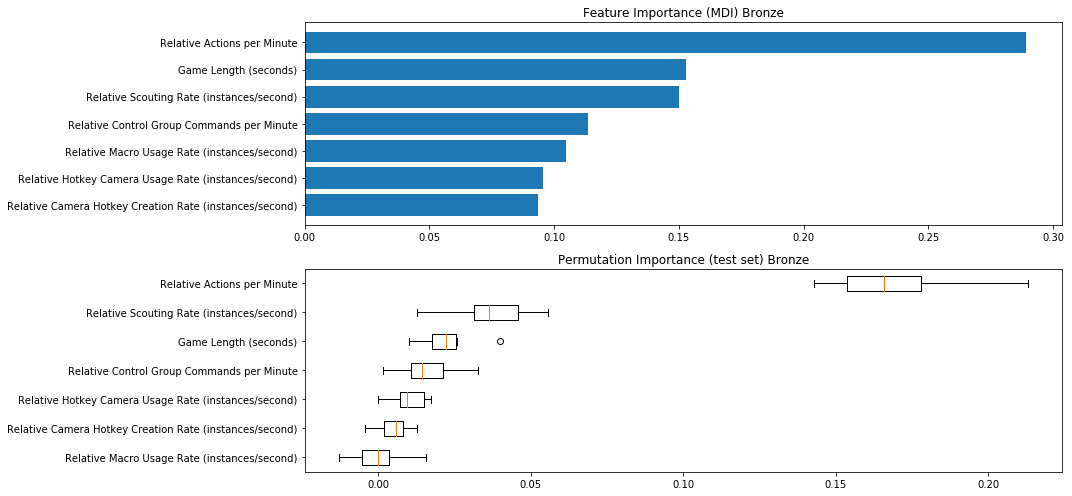

In [55]:
# US feature importance
plot_features_importance(res_win_us)

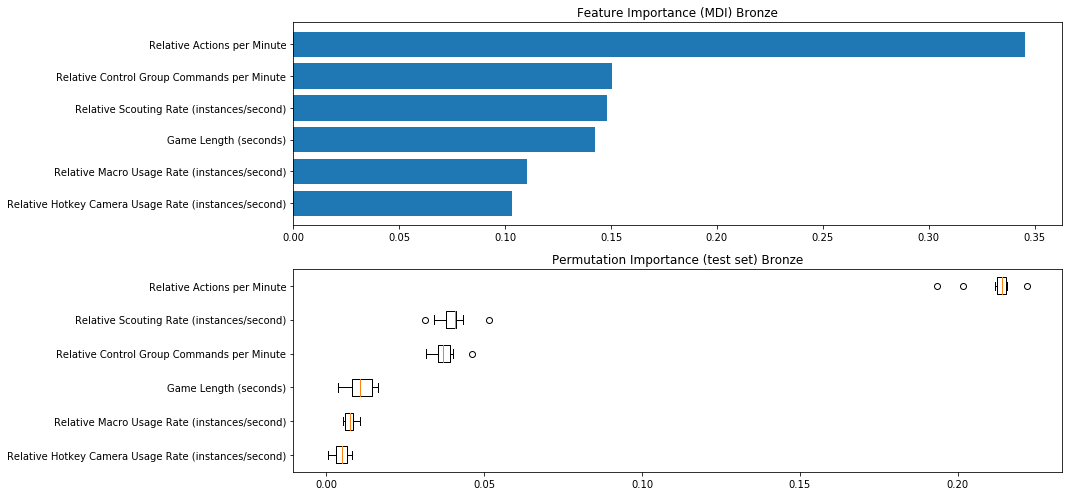

In [56]:
# EU feature importance
plot_features_importance(res_win_eu)

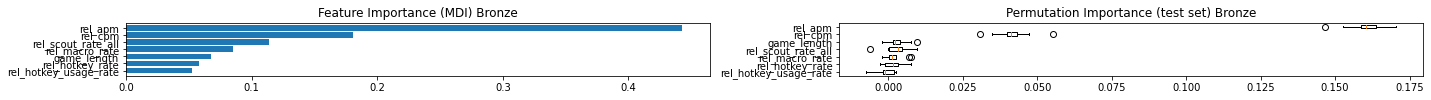

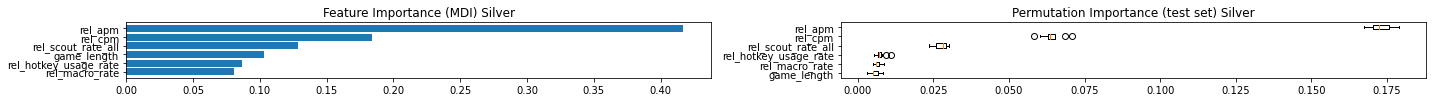

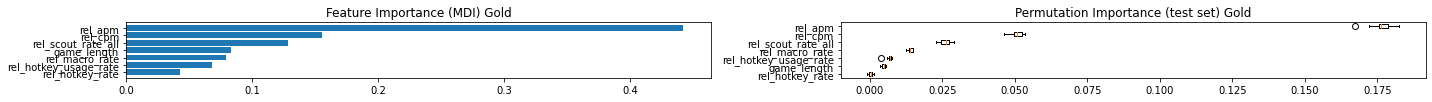

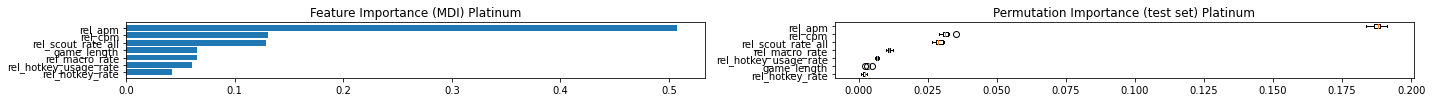

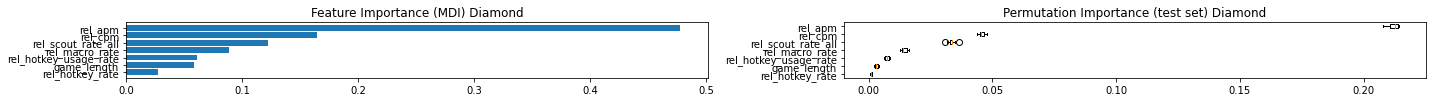

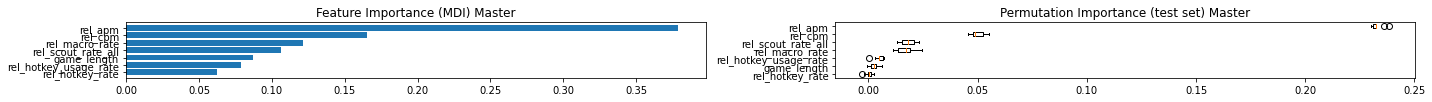

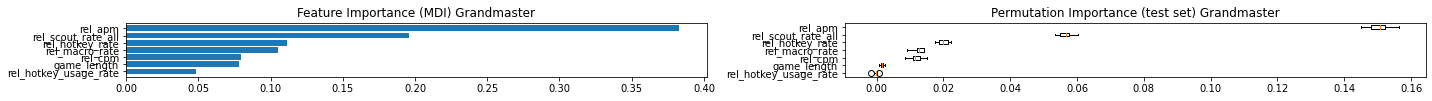

In [237]:
# Winner prediction across ranks
plot_features_importance(res[:7], rank = True)

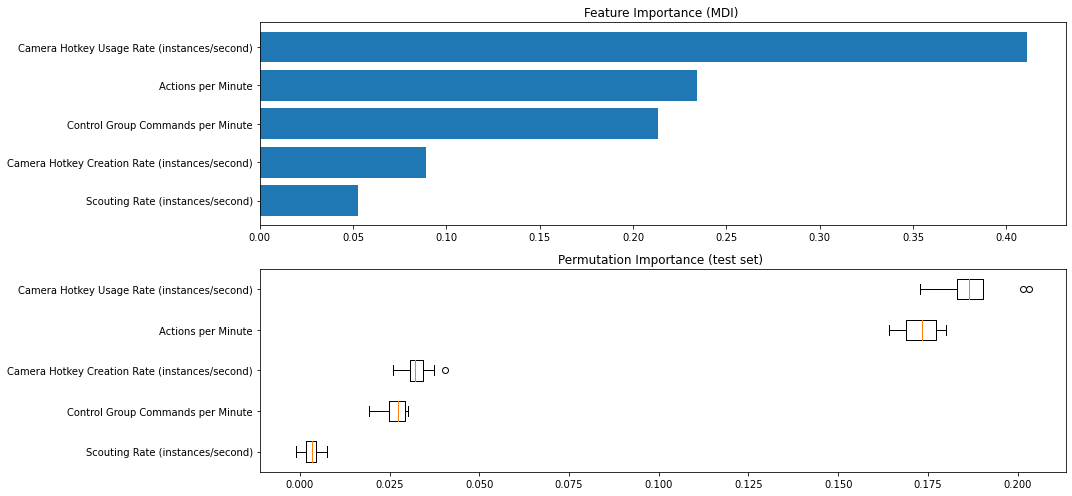

In [16]:
# skill prediction all data
plot_features_importance(res_skill[0:1], skill = True)

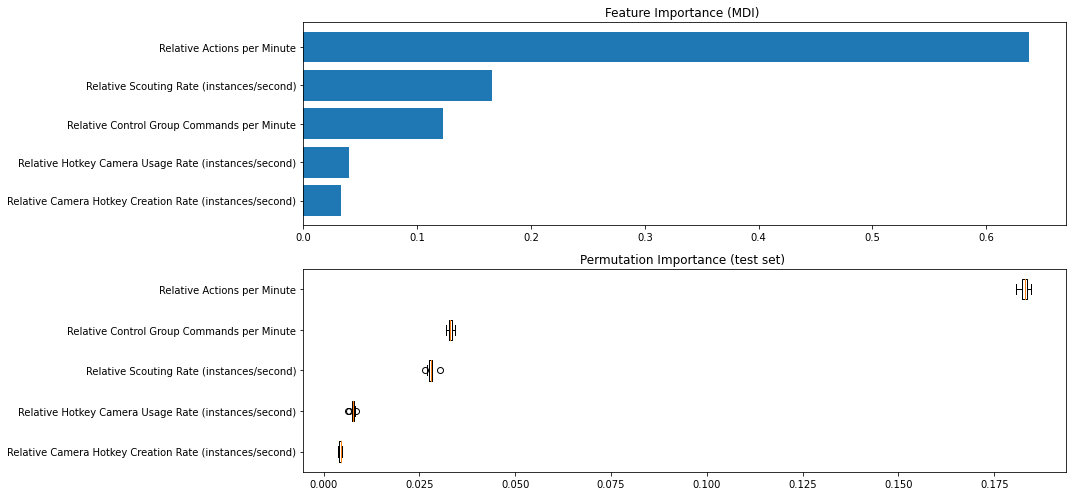

In [15]:
# win prediction all data
plot_features_importance(res[len(res)-1:])

In [272]:
dummyPredict(data, predictors_powerset_win[len(predictors_powerset_win) - 1:],
            ['win'])
dummyPredict(data_uid_skill, predictors_powerset_skill[len(predictors_powerset_skill) - 1:],
            ['skill'])

Baseline accuracy: 0.5115302656286262
Baseline accuracy: 0.3333333333333333


In [8]:
data.Region.unique()
data_by_region = [data[data['Region'] == region] for region in data.Region.unique()]

In [7]:
# Skill all data
res_skill = []
with Pool(15) as pool:
    print("This is all data for skill prediction:")
    var_imp, perm_imp, predictors = predict(data_uid_skill, GradientBoostingClassifier, 
                                            predictors_skill_reviewed,
                                            ['skill'], ParameterGrid(grid_quick), pool)
    res_skill.append((var_imp, perm_imp, predictors))

This is all data for skill prediction:
Accuracy: 0.8179629629629629
95% Confidence Interval 0.8076944294025836 0.8282314965233424
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
